In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [3]:
from scipy.spatial import procrustes
from copy import deepcopy

In [4]:
from fundamental_matrix import keypoint_matcher, get_fundamental_matrix, draw_epipolar_lines, get_fundamental_matrix_ransac

# Matching

In [5]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000002.png")

Before filtering neighbours: 543. After: 450
Before filtering by L2 norm with threshold 0.15: 450. After: 18
Have 18 matches while asking for n_points=20


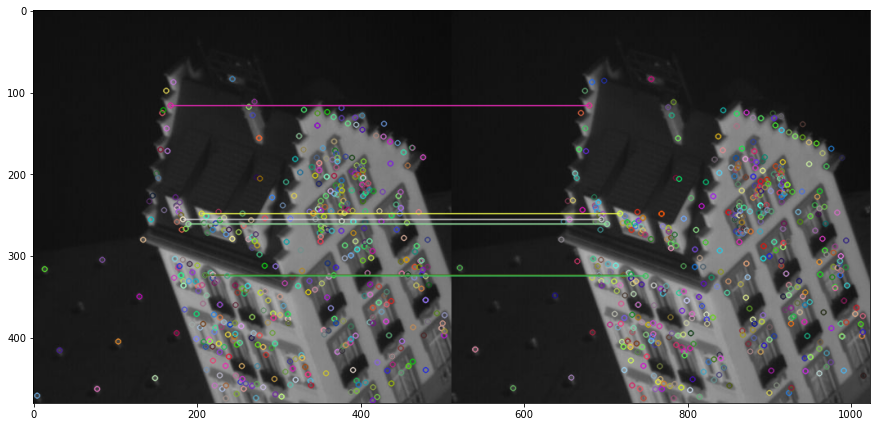

In [25]:
matches, matched_points1, matched_points2, kp1, kp2 = keypoint_matcher(image1, image2, 
                                                                       n_points=20, 
                                                                       distance_threshold=0.15,
                                                                       random_selection=False, 
                                                                       filter_neighbours=True, 
                                                                       draw_matches=True)

In [26]:
[m[0].distance for m in matches]

[8.426149368286133,
 10.488088607788086,
 11.401754379272461,
 13.190905570983887,
 15.0,
 15.033296585083008,
 15.459625244140625,
 16.970561981201172,
 18.055469512939453,
 18.867961883544922,
 22.516660690307617,
 28.301942825317383,
 28.809720993041992,
 31.160873413085938,
 32.06243896484375,
 33.09078598022461,
 73.25981140136719,
 77.88452911376953]

In [27]:
[np.linalg.norm(np.array(p1)-np.array(p2)) for p1, p2 in zip(matched_points1, matched_points2)]

[0.13470990127718457,
 0.09231244546589051,
 0.13470990127718457,
 0.1463027408161432,
 0.14256826866387934,
 0.10113406713016168,
 0.09231244546589051,
 0.127810474535054,
 0.034843497446453535,
 0.054650813808406654,
 0.05055173256909472,
 0.1364783463964474,
 0.09107805666934866,
 0.14866772165275172,
 0.116312499505227,
 0.1463027408161432,
 0.08200815562588643,
 0.13016909137113863]

In [28]:
sorted(matched_points1, key=lambda x: x[0])

[(150.70590209960938, 199.20382690429688),
 (152.74134826660156, 204.7090301513672),
 (167.96371459960938, 116.2098159790039),
 (167.96371459960938, 116.2098159790039),
 (175.68380737304688, 258.3050231933594),
 (175.88623046875, 241.01461791992188),
 (180.70162963867188, 250.08480834960938),
 (181.65159606933594, 267.8046875),
 (182.92825317382812, 255.20550537109375),
 (189.71798706054688, 260.8363037109375),
 (189.71798706054688, 260.8363037109375),
 (201.5600128173828, 336.95306396484375),
 (205.81719970703125, 248.2129669189453),
 (210.1157989501953, 323.3241882324219),
 (210.1157989501953, 323.3241882324219),
 (237.13021850585938, 324.23199462890625),
 (247.0077667236328, 335.88104248046875),
 (262.20440673828125, 336.5632019042969)]

In [29]:
sorted(matched_points2, key=lambda x: x[0])

[(150.79600524902344, 199.2171173095703),
 (152.6868438720703, 204.7050323486328),
 (168.09413146972656, 116.17607879638672),
 (168.09413146972656, 116.17607879638672),
 (175.7934112548828, 258.23480224609375),
 (175.96380615234375, 241.0412139892578),
 (180.5725555419922, 250.129150390625),
 (181.68084716796875, 267.8459167480469),
 (183.0542449951172, 255.22698974609375),
 (189.80917358398438, 260.8506774902344),
 (189.80917358398438, 260.8506774902344),
 (201.4286651611328, 337.022705078125),
 (205.90496826171875, 248.1627197265625),
 (210.0010986328125, 323.4150085449219),
 (210.0010986328125, 323.4150085449219),
 (237.08387756347656, 324.3668212890625),
 (247.01353454589844, 335.8466796875),
 (262.202880859375, 336.67950439453125)]

# Normalization

In [30]:
from fundamental_matrix import normalize_points

In [31]:
matched_points1_norm, T = normalize_points(matched_points1)

mean x: 193.867, mean y: 258.828, average distance to the mean: 57.207


Check and show that the set of points {p_hat} with homogeneous coordinates satisfies our criteria.

In [32]:
normalize_points(matched_points1_norm);

mean x: -0.0, mean y: 0.0, average distance to the mean: 1.414


In [33]:
matched_points2_norm, T_prime = normalize_points(matched_points2)

mean x: 193.888, mean y: 258.853, average distance to the mean: 57.213


In [34]:
normalize_points(matched_points2_norm);

mean x: 0.0, mean y: -0.0, average distance to the mean: 1.414


# Fundamental matrix

In [35]:
matches, matched_points1, matched_points2, kp1, kp2 = keypoint_matcher(image1, image2, 
                                                                       n_points=-1, 
                                                                       distance_threshold=0.5,
                                                                       random_selection=False, 
                                                                       filter_neighbours=True, 
                                                                       draw_matches=False)

Before filtering neighbours: 543. After: 450
Before filtering by L2 norm with threshold 0.5: 450. After: 113


In [36]:
len(matches)

113

In [45]:
from fundamental_matrix import random_colors, drawlines

## Regular 8 point algorithm

U, D, V_t = np.linalg.svd(A) (113, 113) (9,) (9, 9)
V_t.T[:, n - 1]
[-6.56291067e-07  1.47351407e-03 -5.35549809e-01 -1.47462528e-03
 -1.00547474e-06  4.34603248e-01  5.36044364e-01 -4.33568999e-01
 -2.21306205e-01]
(9,)
F
[[-6.56291067e-07  1.47351407e-03 -5.35549809e-01]
 [-1.47462528e-03 -1.00547474e-06  4.34603248e-01]
 [ 5.36044364e-01 -4.33568999e-01 -2.21306205e-01]]
(3, 3)
FD_prime [8.09048867e-01 5.87741381e-01 3.85498026e-08]
FD_prime with the smallest singular value zeroed [0.80904887 0.58774138 0.        ]


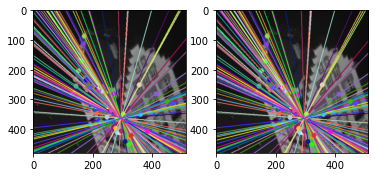

In [58]:
# Regular 8 point algorithm
F = get_fundamental_matrix(matched_points1, matched_points2, normalize=False)
lines1 = cv.computeCorrespondEpilines(np.array(matched_points1), 2, F)
lines1 = lines1.reshape(-1, 3)
colors = random_colors(lines1)
img5, _ = drawlines(image1, image2, lines1,
                    matched_points1, matched_points2, colors)
lines2 = cv.computeCorrespondEpilines(np.array(matched_points2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, _ = drawlines(image2, image1, lines2,
                    matched_points2, matched_points1, colors)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
final = cv.hconcat((img5, img3))
cv.imwrite('../images/8point.png', final)
plt.show()

In [59]:
F

array([[-6.41014955e-07,  1.47353293e-03, -5.35549809e-01],
       [-1.47460642e-03, -9.82201230e-07,  4.34603248e-01],
       [ 5.36044364e-01, -4.33568999e-01, -2.21306205e-01]])

In [60]:
F_cv = cv.findFundamentalMat(np.float64(matched_points1), np.float64(matched_points2), cv.FM_8POINT)[0]
F_cv

array([[-6.81038212e-06,  3.92929241e-03, -2.25240538e+00],
       [-3.90812073e-03, -7.18700520e-06,  1.82520826e+00],
       [ 2.25170564e+00, -1.82954606e+00,  1.00000000e+00]])

Similar, but not the same

## 8 point algorithm with normalization

mean x: 233.632, mean y: 311.445, average distance to the mean: 84.614
mean x: 233.582, mean y: 311.556, average distance to the mean: 84.708
U, D, V_t = np.linalg.svd(A) (113, 113) (9,) (9, 9)
V_t.T[:, n - 1]
[-2.67981289e-04 -1.18525526e-01  5.22474089e-01  1.19028004e-01
 -2.96577430e-04 -4.62520992e-01 -5.21932529e-01  4.60938830e-01
  9.28662434e-04]
(9,)
F
[[-2.67981289e-04 -1.18525526e-01  5.22474089e-01]
 [ 1.19028004e-01 -2.96577430e-04 -4.62520992e-01]
 [-5.21932529e-01  4.60938830e-01  9.28662434e-04]]
(3, 3)
FD_prime [7.08163100e-01 7.06048868e-01 1.44368862e-04]
FD_prime with the smallest singular value zeroed [0.7081631  0.70604887 0.        ]


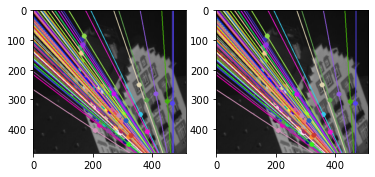

In [64]:
# 8 point algorithm with normalization
F = get_fundamental_matrix(matched_points1, matched_points2, normalize=True)
lines1 = cv.computeCorrespondEpilines(np.array(matched_points1), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, _ = drawlines(image1, image2, lines1,
                    matched_points1, matched_points2, colors)
lines2 = cv.computeCorrespondEpilines(np.array(matched_points2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, _ = drawlines(image2, image1, lines2,
                    matched_points2, matched_points1, colors)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
final = cv.hconcat((img5, img3))
cv.imwrite('../images/8point_normalized.png', final)
plt.show()

In [65]:
F

array([[-5.76006090e-08, -3.30539653e-05,  1.90310306e-02],
       [ 3.32330304e-05, -6.07859984e-08, -1.54669709e-02],
       [-1.90636953e-02,  1.54440749e-02,  1.30040006e-02]])

In [66]:
F_cv

array([[-6.81038212e-06,  3.92929241e-03, -2.25240538e+00],
       [-3.90812073e-03, -7.18700520e-06,  1.82520826e+00],
       [ 2.25170564e+00, -1.82954606e+00,  1.00000000e+00]])

## 8 point algoirhtm with RANSAC and normalization

mean x: 262.262, mean y: 364.106, average distance to the mean: 82.761
mean x: 261.993, mean y: 364.299, average distance to the mean: 82.908
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-3.59007321e-04 -3.48205364e-01  6.16630906e-01  3.52855764e-01
 -3.60404880e-03 -4.50575805e-03 -6.11524489e-01 -3.66964348e-04
  4.05030717e-03]
(9,)
F
[[-3.59007321e-04 -3.48205364e-01  6.16630906e-01]
 [ 3.52855764e-01 -3.60404880e-03 -4.50575805e-03]
 [-6.11524489e-01 -3.66964348e-04  4.05030717e-03]]
(3, 3)
FD_prime [0.70964957 0.70454456 0.00380148]
FD_prime with the smallest singular value zeroed [0.70964957 0.70454456 0.        ]
new best number of inliers 109
mean x: 255.62, mean y: 306.7, average distance to the mean: 107.023
mean x: 255.6, mean y: 306.754, average distance to the mean: 107.27
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 0.00224906 -0.45388356 -0.41363134  0.45217203  0.00320375  0.35527974
  0.41149275 -0.35051539 -0.00359696]
(9,)
F

mean x: 204.788, mean y: 263.997, average distance to the mean: 72.369
mean x: 204.834, mean y: 264.078, average distance to the mean: 72.479
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 2.18002831e-03  4.97499781e-02 -9.70419711e-02 -5.21761682e-02
  5.18138310e-04  6.97932241e-01  9.93849543e-02 -6.98851497e-01
 -4.73310673e-04]
(9,)
F
[[ 2.18002831e-03  4.97499781e-02 -9.70419711e-02]
 [-5.21761682e-02  5.18138310e-04  6.97932241e-01]
 [ 9.93849543e-02 -6.98851497e-01 -4.73310673e-04]]
(3, 3)
FD_prime [0.7080169  0.70619277 0.00195892]
FD_prime with the smallest singular value zeroed [0.7080169  0.70619277 0.        ]
mean x: 230.653, mean y: 311.648, average distance to the mean: 88.859
mean x: 230.518, mean y: 311.64, average distance to the mean: 88.813
U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[-0.00169418  0.23192471  0.66397577 -0.22930863 -0.00162778 -0.09116974
 -0.66087232  0.08771312  0.00117836]
(9,)
F
[[-0.00169418  0.23192471  

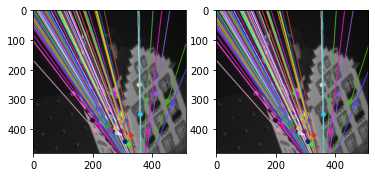

In [67]:
# 8 point algoirhtm with RANSAC and normalization
F = get_fundamental_matrix_ransac(matched_points1, matched_points2)
lines1 = cv.computeCorrespondEpilines(np.array(matched_points1), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, _ = drawlines(image1, image2, lines1,
                    matched_points1, matched_points2, colors)
lines2 = cv.computeCorrespondEpilines(np.array(matched_points2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, _ = drawlines(image2, image1, lines2,
                    matched_points2, matched_points1, colors)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
final = cv.hconcat((img5, img3))
cv.imwrite('../images/8point_normalized_ransac.png', final)
plt.show()

In [68]:
F

array([[ 7.62323636e-08,  3.26937123e-05, -1.89936084e-02],
       [-3.29269845e-05,  4.67230134e-08,  1.19051916e-02],
       [ 1.90117170e-02, -1.18580179e-02, -1.06235593e-02]])

In [69]:
cv.findFundamentalMat(np.float64(matched_points1), np.float64(matched_points2), cv.FM_RANSAC, 1)[0]

array([[ 1.00239540e-06,  1.57043794e-02, -5.84523696e+00],
       [-1.57315625e-02,  4.24660273e-05,  3.55406596e+00],
       [ 5.85859020e+00, -3.57466984e+00,  1.00000000e+00]])

# Chaining

Construct a point-view matrix for chaining multiple views with the matches found in last step using all consecutive house images (1-2, 2-3, 3-4, ..., 48-49, 49-1). Rows of the point-view matrix will be representing your images while columns will be points. For more details, you can refer to [2].
1. Start from any two consecutive image matches. Add a new column to point-view matrix for each newly introduced point.
2. If a point which is already introduced in the point-view matrix and another image contains that point, mark this matching on your point-view matrix using the previously defined point column. Do not introduce a new column.  

Together with the assignment a sample point view matrix (PointViewMatrix.txt) is provided to test and finish your pipeline (for the ones who have difficult time to build a point view matrix). This data has more images than provided for the assignment, however you can still use PVM to check correctness of the last part of your algorithm.

In [4]:
from chaining import get_names_image_pair, chaining

In [5]:
sparse_fill_value=-1e-4

In [6]:
PVM = chaining(sparse_fill_value=sparse_fill_value, 
               n_points=500, distance_threshold=1,) # a lot of points but very careful

  2%|▏         | 1/48 [00:00<00:10,  4.58it/s]

comparing table x indices (0, 2) and images ('../Data/House/frame00000001.png', '../Data/House/frame00000002.png')
Before filtering neighbours: 543. After: 450
Before filtering by L2 norm with threshold 1: 450. After: 329


  4%|▍         | 2/48 [00:00<00:08,  5.56it/s]

comparing table x indices (2, 4) and images ('../Data/House/frame00000002.png', '../Data/House/frame00000003.png')
Before filtering neighbours: 548. After: 447
Before filtering by L2 norm with threshold 1: 447. After: 191
comparing table x indices (4, 6) and images ('../Data/House/frame00000003.png', '../Data/House/frame00000004.png')


  6%|▋         | 3/48 [00:00<00:07,  6.00it/s]

Before filtering neighbours: 526. After: 424
Before filtering by L2 norm with threshold 1: 424. After: 192
comparing table x indices (6, 8) and images ('../Data/House/frame00000004.png', '../Data/House/frame00000005.png')
Before filtering neighbours: 566. After: 450


  8%|▊         | 4/48 [00:00<00:08,  4.95it/s]

Before filtering by L2 norm with threshold 1: 450. After: 192
comparing table x indices (8, 10) and images ('../Data/House/frame00000005.png', '../Data/House/frame00000006.png')


 10%|█         | 5/48 [00:01<00:13,  3.30it/s]

Before filtering neighbours: 525. After: 424
Before filtering by L2 norm with threshold 1: 424. After: 198
comparing table x indices (10, 12) and images ('../Data/House/frame00000006.png', '../Data/House/frame00000007.png')


 12%|█▎        | 6/48 [00:01<00:12,  3.27it/s]

Before filtering neighbours: 554. After: 437
Before filtering by L2 norm with threshold 1: 437. After: 214
comparing table x indices (12, 14) and images ('../Data/House/frame00000007.png', '../Data/House/frame00000008.png')


 15%|█▍        | 7/48 [00:01<00:11,  3.66it/s]

Before filtering neighbours: 534. After: 434
Before filtering by L2 norm with threshold 1: 434. After: 214
comparing table x indices (14, 16) and images ('../Data/House/frame00000008.png', '../Data/House/frame00000009.png')


 19%|█▉        | 9/48 [00:02<00:08,  4.48it/s]

Before filtering neighbours: 540. After: 448
Before filtering by L2 norm with threshold 1: 448. After: 228
comparing table x indices (16, 18) and images ('../Data/House/frame00000009.png', '../Data/House/frame00000010.png')
Before filtering neighbours: 561. After: 455
Before filtering by L2 norm with threshold 1: 455. After: 211
comparing table x indices (18, 20) and images ('../Data/House/frame00000010.png', '../Data/House/frame00000011.png')


 23%|██▎       | 11/48 [00:02<00:06,  5.37it/s]

Before filtering neighbours: 549. After: 453
Before filtering by L2 norm with threshold 1: 453. After: 227
comparing table x indices (20, 22) and images ('../Data/House/frame00000011.png', '../Data/House/frame00000012.png')
Before filtering neighbours: 550. After: 440
Before filtering by L2 norm with threshold 1: 440. After: 237
comparing table x indices (22, 24) and images ('../Data/House/frame00000012.png', '../Data/House/frame00000013.png')


 27%|██▋       | 13/48 [00:02<00:05,  6.04it/s]

Before filtering neighbours: 555. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 239
comparing table x indices (24, 26) and images ('../Data/House/frame00000013.png', '../Data/House/frame00000014.png')
Before filtering neighbours: 558. After: 450
Before filtering by L2 norm with threshold 1: 450. After: 244
comparing table x indices (26, 28) and images ('../Data/House/frame00000014.png', '../Data/House/frame00000015.png')


 31%|███▏      | 15/48 [00:03<00:05,  6.03it/s]

Before filtering neighbours: 573. After: 479
Before filtering by L2 norm with threshold 1: 479. After: 267
comparing table x indices (28, 30) and images ('../Data/House/frame00000015.png', '../Data/House/frame00000016.png')
Before filtering neighbours: 573. After: 457
Before filtering by L2 norm with threshold 1: 457. After: 262


 33%|███▎      | 16/48 [00:03<00:05,  6.25it/s]

comparing table x indices (30, 32) and images ('../Data/House/frame00000016.png', '../Data/House/frame00000017.png')
Before filtering neighbours: 549. After: 458
Before filtering by L2 norm with threshold 1: 458. After: 243
comparing table x indices (32, 34) and images ('../Data/House/frame00000017.png', '../Data/House/frame00000018.png')


 35%|███▌      | 17/48 [00:03<00:05,  5.82it/s]

Before filtering neighbours: 571. After: 476
Before filtering by L2 norm with threshold 1: 476. After: 264
comparing table x indices (34, 36) and images ('../Data/House/frame00000018.png', '../Data/House/frame00000019.png')
Before filtering neighbours: 584. After: 475
Before filtering by L2 norm with threshold 1: 475. After: 274


 40%|███▉      | 19/48 [00:03<00:05,  5.54it/s]

comparing table x indices (36, 38) and images ('../Data/House/frame00000019.png', '../Data/House/frame00000020.png')
Before filtering neighbours: 561. After: 462
Before filtering by L2 norm with threshold 1: 462. After: 274
comparing table x indices (38, 40) and images ('../Data/House/frame00000020.png', '../Data/House/frame00000021.png')


 42%|████▏     | 20/48 [00:03<00:04,  5.60it/s]

Before filtering neighbours: 579. After: 469
Before filtering by L2 norm with threshold 1: 469. After: 293
comparing table x indices (40, 42) and images ('../Data/House/frame00000021.png', '../Data/House/frame00000022.png')
Before filtering neighbours: 574. After: 478
Before filtering by L2 norm with threshold 1: 478. After: 262


 46%|████▌     | 22/48 [00:04<00:04,  5.56it/s]

comparing table x indices (42, 44) and images ('../Data/House/frame00000022.png', '../Data/House/frame00000023.png')
Before filtering neighbours: 560. After: 434
Before filtering by L2 norm with threshold 1: 434. After: 251
comparing table x indices (44, 46) and images ('../Data/House/frame00000023.png', '../Data/House/frame00000024.png')


 48%|████▊     | 23/48 [00:04<00:04,  5.26it/s]

Before filtering neighbours: 565. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 269
comparing table x indices (46, 48) and images ('../Data/House/frame00000024.png', '../Data/House/frame00000025.png')
Before filtering neighbours: 590. After: 485
Before filtering by L2 norm with threshold 1: 485. After: 298


 50%|█████     | 24/48 [00:04<00:04,  5.22it/s]

comparing table x indices (48, 50) and images ('../Data/House/frame00000025.png', '../Data/House/frame00000026.png')
Before filtering neighbours: 572. After: 458
Before filtering by L2 norm with threshold 1: 458. After: 277


 52%|█████▏    | 25/48 [00:04<00:04,  4.90it/s]

comparing table x indices (50, 52) and images ('../Data/House/frame00000026.png', '../Data/House/frame00000027.png')
Before filtering neighbours: 555. After: 441
Before filtering by L2 norm with threshold 1: 441. After: 285


 56%|█████▋    | 27/48 [00:05<00:04,  4.73it/s]

comparing table x indices (52, 54) and images ('../Data/House/frame00000027.png', '../Data/House/frame00000028.png')
Before filtering neighbours: 579. After: 435
Before filtering by L2 norm with threshold 1: 435. After: 295
comparing table x indices (54, 56) and images ('../Data/House/frame00000028.png', '../Data/House/frame00000029.png')


 58%|█████▊    | 28/48 [00:05<00:04,  4.85it/s]

Before filtering neighbours: 578. After: 460
Before filtering by L2 norm with threshold 1: 460. After: 283
comparing table x indices (56, 58) and images ('../Data/House/frame00000029.png', '../Data/House/frame00000030.png')
Before filtering neighbours: 543. After: 445
Before filtering by L2 norm with threshold 1: 445. After: 279


 62%|██████▎   | 30/48 [00:06<00:03,  4.96it/s]

comparing table x indices (58, 60) and images ('../Data/House/frame00000030.png', '../Data/House/frame00000031.png')
Before filtering neighbours: 567. After: 455
Before filtering by L2 norm with threshold 1: 455. After: 273


 65%|██████▍   | 31/48 [00:06<00:03,  4.94it/s]

comparing table x indices (60, 62) and images ('../Data/House/frame00000031.png', '../Data/House/frame00000032.png')
Before filtering neighbours: 552. After: 441
Before filtering by L2 norm with threshold 1: 441. After: 281
comparing table x indices (62, 64) and images ('../Data/House/frame00000032.png', '../Data/House/frame00000033.png')
Before filtering neighbours: 574. After: 469
Before filtering by L2 norm with threshold 1: 469. After: 310


 69%|██████▉   | 33/48 [00:06<00:03,  4.69it/s]

comparing table x indices (64, 66) and images ('../Data/House/frame00000033.png', '../Data/House/frame00000034.png')
Before filtering neighbours: 580. After: 436
Before filtering by L2 norm with threshold 1: 436. After: 289
comparing table x indices (66, 68) and images ('../Data/House/frame00000034.png', '../Data/House/frame00000035.png')
Before filtering neighbours: 546. After: 439
Before filtering by L2 norm with threshold 1: 439. After: 291


 71%|███████   | 34/48 [00:06<00:03,  4.51it/s]

comparing table x indices (68, 70) and images ('../Data/House/frame00000035.png', '../Data/House/frame00000036.png')
Before filtering neighbours: 571. After: 438
Before filtering by L2 norm with threshold 1: 438. After: 286


 73%|███████▎  | 35/48 [00:07<00:03,  4.33it/s]

comparing table x indices (70, 72) and images ('../Data/House/frame00000036.png', '../Data/House/frame00000037.png')
Before filtering neighbours: 543. After: 454
Before filtering by L2 norm with threshold 1: 454. After: 300


 75%|███████▌  | 36/48 [00:07<00:02,  4.19it/s]

comparing table x indices (72, 74) and images ('../Data/House/frame00000037.png', '../Data/House/frame00000038.png')
Before filtering neighbours: 567. After: 453
Before filtering by L2 norm with threshold 1: 453. After: 303


 77%|███████▋  | 37/48 [00:07<00:02,  4.25it/s]

comparing table x indices (74, 76) and images ('../Data/House/frame00000038.png', '../Data/House/frame00000039.png')
Before filtering neighbours: 567. After: 458
Before filtering by L2 norm with threshold 1: 458. After: 305


 79%|███████▉  | 38/48 [00:07<00:02,  4.31it/s]

comparing table x indices (76, 78) and images ('../Data/House/frame00000039.png', '../Data/House/frame00000040.png')
Before filtering neighbours: 559. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 319


 81%|████████▏ | 39/48 [00:08<00:02,  4.20it/s]

comparing table x indices (78, 80) and images ('../Data/House/frame00000040.png', '../Data/House/frame00000041.png')
Before filtering neighbours: 586. After: 465
Before filtering by L2 norm with threshold 1: 465. After: 329


 83%|████████▎ | 40/48 [00:08<00:02,  3.95it/s]

comparing table x indices (80, 82) and images ('../Data/House/frame00000041.png', '../Data/House/frame00000042.png')
Before filtering neighbours: 583. After: 481
Before filtering by L2 norm with threshold 1: 481. After: 328


 85%|████████▌ | 41/48 [00:08<00:01,  3.80it/s]

comparing table x indices (82, 84) and images ('../Data/House/frame00000042.png', '../Data/House/frame00000043.png')
Before filtering neighbours: 577. After: 458
Before filtering by L2 norm with threshold 1: 458. After: 309


 88%|████████▊ | 42/48 [00:08<00:01,  3.84it/s]

comparing table x indices (84, 86) and images ('../Data/House/frame00000043.png', '../Data/House/frame00000044.png')
Before filtering neighbours: 563. After: 449
Before filtering by L2 norm with threshold 1: 449. After: 313


 90%|████████▉ | 43/48 [00:09<00:01,  3.79it/s]

comparing table x indices (86, 88) and images ('../Data/House/frame00000044.png', '../Data/House/frame00000045.png')
Before filtering neighbours: 537. After: 446
Before filtering by L2 norm with threshold 1: 446. After: 319


 92%|█████████▏| 44/48 [00:09<00:01,  3.33it/s]

comparing table x indices (88, 90) and images ('../Data/House/frame00000045.png', '../Data/House/frame00000046.png')
Before filtering neighbours: 587. After: 481
Before filtering by L2 norm with threshold 1: 481. After: 355


 94%|█████████▍| 45/48 [00:09<00:00,  3.14it/s]

comparing table x indices (90, 92) and images ('../Data/House/frame00000046.png', '../Data/House/frame00000047.png')
Before filtering neighbours: 578. After: 462
Before filtering by L2 norm with threshold 1: 462. After: 330


 96%|█████████▌| 46/48 [00:10<00:00,  3.25it/s]

comparing table x indices (92, 94) and images ('../Data/House/frame00000047.png', '../Data/House/frame00000048.png')
Before filtering neighbours: 563. After: 452
Before filtering by L2 norm with threshold 1: 452. After: 319


 98%|█████████▊| 47/48 [00:10<00:00,  3.32it/s]

comparing table x indices (94, 96) and images ('../Data/House/frame00000048.png', '../Data/House/frame00000049.png')
Before filtering neighbours: 556. After: 439
Before filtering by L2 norm with threshold 1: 439. After: 312


100%|██████████| 48/48 [00:10<00:00,  4.44it/s]


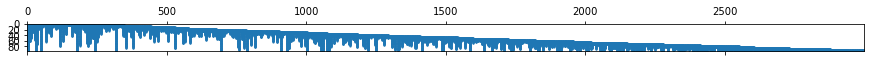

In [7]:
# Implementation of matplotlib spy function
import matplotlib.pyplot as plt
import numpy as np
 
    
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=-sparse_fill_value, markersize = 1);

In [8]:
PVM.shape

(98, 2998)

## Densification

### Drop non-perfect cols

## Comparing with PointViewMatrix.txt

In [12]:
gt_pvm = np.loadtxt('../PointViewMatrix.txt')
gt_pvm.shape

(202, 215)

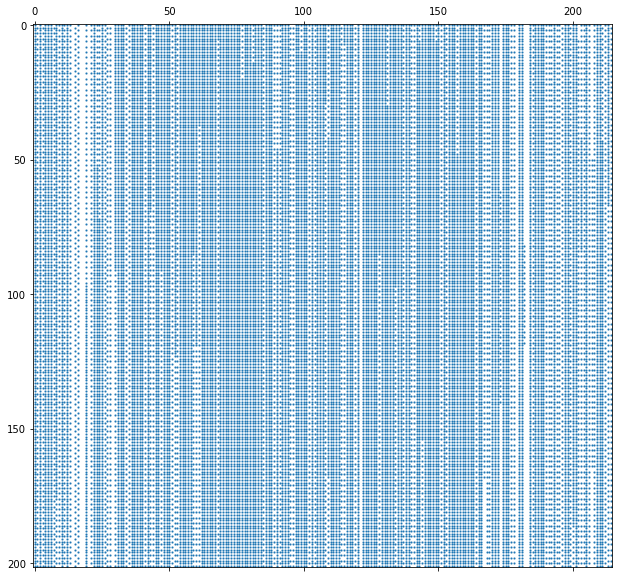

In [13]:
plt.figure(figsize=(15, 10))
plt.spy(gt_pvm, precision=200, markersize = 1);

Q: how to extract dense blocks?

# Chaining check

Before filtering neighbours: 543. After: 450
Before filtering neighbours: 548. After: 447


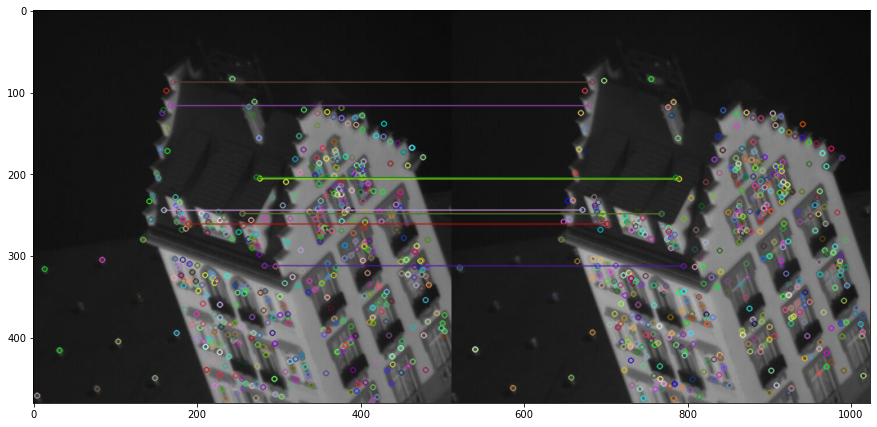

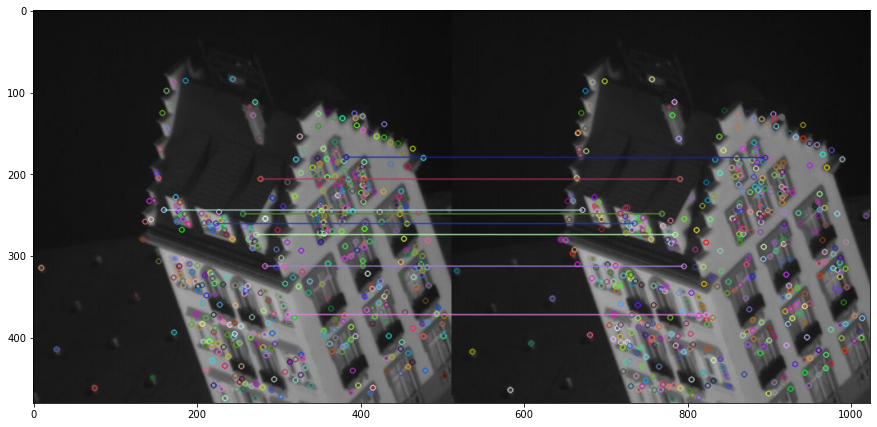

In [141]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000002.png")
image3 = cv.imread("../Data/House/frame00000003.png")

_, matched_points12, matched_points21, _, _ = keypoint_matcher(
    image1, image2, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

_, matched_points23, matched_points32, _, _ = keypoint_matcher(
    image2, image3, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

In [144]:
sorted(matched_points21, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (168.09413146972656, 116.17607879638672),
 (171.5107879638672, 87.54129791259766),
 (189.80917358398438, 260.8506774902344),
 (256.4742431640625, 248.44085693359375),
 (273.99774169921875, 204.6702880859375),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875)]

In [145]:
sorted(matched_points23, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (223.43911743164062, 260.18743896484375),
 (256.4742431640625, 248.44085693359375),
 (272.61663818359375, 273.8099670410156),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875),
 (311.4600830078125, 371.3696594238281),
 (382.78680419921875, 179.23373413085938)]

In [11]:
PVM[2, :20]

array([ 2.77999908e+02,  1.59843262e+02,  1.68094131e+02,  2.73997742e+02,
        2.83414673e+02,  1.89809174e+02,  1.71510788e+02,  2.56474243e+02,
        2.23439117e+02,  3.82786804e+02,  2.77999908e+02,  2.72616638e+02,
        2.83414673e+02,  3.11460083e+02,  2.56474243e+02,  1.59843262e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])

In [12]:
PVM[3, :20]

array([ 2.05904709e+02,  2.43742966e+02,  1.16176079e+02,  2.04670288e+02,
        3.12281128e+02,  2.60850677e+02,  8.75412979e+01,  2.48440857e+02,
        2.60187439e+02,  1.79233734e+02,  2.05904709e+02,  2.73809967e+02,
        3.12281128e+02,  3.71369659e+02,  2.48440857e+02,  2.43742966e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])

# Structure from motion

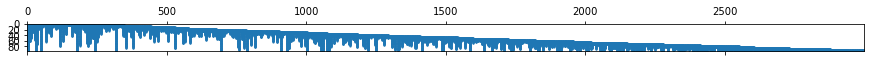

In [9]:
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=1e-4, markersize = 1);

In [14]:
from sfm import factorize_and_stitch

## GT PVM

In [15]:
gt_pvm.shape

(202, 215)

### Full

In [16]:
S = factorize_and_stitch(gt_pvm)
S.shape

2m:  202
n:  215


(3, 215)

In [17]:
trace_S = (S @ S.T).trace()
S_stand = S / np.sqrt(trace_S)

In [20]:
import open3d as o3d

In [21]:
gt_pvm_point = o3d.geometry.PointCloud()
gt_pvm_point.points = o3d.utility.Vector3dVector(S_stand.T)
o3d.visualization.draw_geometries([gt_pvm_point])    

works perfect

### Vetrical split

In [22]:
S1 = factorize_and_stitch(gt_pvm[:, :100])
S2 = factorize_and_stitch(gt_pvm[:, 100: 200])
S1.shape, S2.shape

2m:  202
n:  100
2m:  202
n:  100


((3, 100), (3, 100))

In [25]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [26]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

o3d.visualization.draw_geometries([p1, p2]) 

In [449]:
o3d.visualization.draw_geometries([gt_pvm_point, p2]) 

works bad

### Horizontal halfs

In [27]:
S1 = factorize_and_stitch(gt_pvm[:100, :])
S2 = factorize_and_stitch(gt_pvm[100: 200, :])
S1.shape, S2.shape

2m:  100
n:  215
2m:  100
n:  215


((3, 215), (3, 215))

In [28]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [29]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

o3d.visualization.draw_geometries([gt_pvm_point, p1, p2]) 

works pretty well

### 3 horizontal parts alligned to the first

In [30]:
gt_pvm.shape

(202, 215)

In [31]:
S1 = factorize_and_stitch(gt_pvm[:65, :])
S2 = factorize_and_stitch(gt_pvm[65: 130, :])
S3 = factorize_and_stitch(gt_pvm[130: 195, :])
S1.shape, S2.shape, S3.shape

2m:  65
n:  215
2m:  65
n:  215
2m:  65
n:  215


((3, 215), (3, 215), (3, 215))

In [32]:
mtx1, mtx2, disparity = procrustes(S1.T, S2.T)

trace_2 = (mtx2 @ mtx2.T).trace()
mtx2_stand = mtx2 / np.sqrt(trace_2)

assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [33]:
mtx1, mtx3, disparity = procrustes(S1.T, S3.T)

trace_3 = (mtx3 @ mtx3.T).trace()
mtx3_stand = mtx3 / np.sqrt(trace_3)

assert np.isclose((mtx3_stand @ mtx3_stand.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1., 
                  rtol=1e-05, atol=1e-08)

In [34]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

p3 = o3d.geometry.PointCloud()
p3.points = o3d.utility.Vector3dVector(mtx3_stand)

o3d.visualization.draw_geometries([p1, p2, p3]) 

works pretty well

### 3 horizontal parts alligned cumulatively

In [35]:
mtx1.shape, mtx2_stand.shape, S3.T.shape

((215, 3), (215, 3), (215, 3))

In [36]:
np.vstack([mtx1, mtx2_stand]).shape

(430, 3)

In [39]:
np.pad(S3.T, [(0, 215), (0, 0)], constant_values=0).shape

(430, 3)

In [40]:
mtx1, mtx3, disparity = procrustes(np.vstack([mtx1, mtx2_stand]),
                                   np.pad(S3.T, [(0, 215), (0, 0)], constant_values=0))

trace_3 = (mtx3 @ mtx3.T).trace()
mtx3_stand = mtx3 / np.sqrt(trace_3)

assert np.isclose((mtx3_stand @ mtx3_stand.T).trace(), 1.,
                  rtol=1e-05, atol=1e-08)
assert np.isclose((mtx1 @ mtx1.T).trace(), 1.,
                  rtol=1e-05, atol=1e-08)

In [41]:
p1 = o3d.geometry.PointCloud()
p1.points = o3d.utility.Vector3dVector(mtx1)

p2 = o3d.geometry.PointCloud()
p2.points = o3d.utility.Vector3dVector(mtx2_stand)

p3 = o3d.geometry.PointCloud()
p3.points = o3d.utility.Vector3dVector(mtx3_stand)

o3d.visualization.draw_geometries([p1, p2, p3]) 

also well

## 3 images

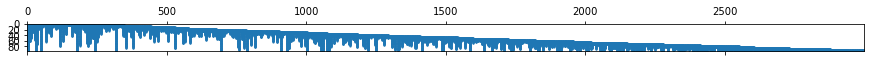

In [44]:
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=1e-4, markersize = 1);

Briefly, we find a dense block for each patch—that is, for each column in the patch-view matrix—by searching for all other patches that are visible in at least the same views. In practice, this strategy provides both a good coverage of the data by dense blocks, and an adequate overlap between blocks. Typically, patches appear in at least three or four views, depending on the separation between successive views in the sequence, and there are in general two orders of magnitude more patches than views.

In [45]:
def find_nonzero_runs(a):
    # Create an array that is 1 where a is nonzero, and pad each end with an extra 0.
    isnonzero = np.concatenate(([0], (np.asarray(a) != sparse_fill_value).view(np.int8), [0]))
    absdiff = np.abs(np.diff(isnonzero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [46]:
patches_num = PVM.shape[1]
min_number_of_patches = 3
min_number_of_images = 3

dense_blocks_list = []

for i in range(patches_num-1):  # the last column may not start a block
    sequences = find_nonzero_runs(PVM[:, i])
    longest_seq = max(sequences, key=lambda x: x[1] - x[0])
    print(f'in column {i} the longest sequence indices: {longest_seq}')

    seq_len = longest_seq[1] - longest_seq[0]
    if seq_len < min_number_of_images*2:
        print(f'less than {min_number_of_images} images')
        continue
    else:
        for j in range(i+1, patches_num):
            # by searching for all other patches that are visible in at least the same views
            if any(PVM[longest_seq[0]: longest_seq[1], j] == sparse_fill_value):  # seq end condition
                if j - i > min_number_of_patches - 1:  # at least 2 points matched
                    dense_blocks_list.append((longest_seq[0], longest_seq[1], i, j))
                else:
                    print('do not make a dense matrix from one patch')
                break
            else:
                print('dense block is rising')

in column 0 the longest sequence indices: [0 4]
less than 3 images
in column 1 the longest sequence indices: [ 0 84]
dense block is rising
do not make a dense matrix from one patch
in column 2 the longest sequence indices: [ 0 98]
do not make a dense matrix from one patch
in column 3 the longest sequence indices: [ 0 44]
dense block is rising
dense block is rising
in column 4 the longest sequence indices: [ 0 98]
do not make a dense matrix from one patch
in column 5 the longest sequence indices: [ 0 66]
do not make a dense matrix from one patch
in column 6 the longest sequence indices: [ 0 10]
dense block is rising
do not make a dense matrix from one patch
in column 7 the longest sequence indices: [ 0 62]
do not make a dense matrix from one patch
in column 8 the longest sequence indices: [0 4]
less than 3 images
in column 9 the longest sequence indices: [0 4]
less than 3 images
in column 10 the longest sequence indices: [ 0 62]
do not make a dense matrix from one patch
in column 11 the

do not make a dense matrix from one patch
in column 627 the longest sequence indices: [18 24]
do not make a dense matrix from one patch
in column 628 the longest sequence indices: [18 22]
less than 3 images
in column 629 the longest sequence indices: [18 24]
dense block is rising
dense block is rising
in column 630 the longest sequence indices: [18 26]
dense block is rising
do not make a dense matrix from one patch
in column 631 the longest sequence indices: [18 26]
do not make a dense matrix from one patch
in column 632 the longest sequence indices: [18 22]
less than 3 images
in column 633 the longest sequence indices: [18 24]
do not make a dense matrix from one patch
in column 634 the longest sequence indices: [18 22]
less than 3 images
in column 635 the longest sequence indices: [18 22]
less than 3 images
in column 636 the longest sequence indices: [18 24]
dense block is rising
dense block is rising
in column 637 the longest sequence indices: [18 24]
dense block is rising
do not mak

do not make a dense matrix from one patch
in column 1076 the longest sequence indices: [34 42]
dense block is rising
do not make a dense matrix from one patch
in column 1077 the longest sequence indices: [34 98]
do not make a dense matrix from one patch
in column 1078 the longest sequence indices: [34 40]
dense block is rising
do not make a dense matrix from one patch
in column 1079 the longest sequence indices: [34 44]
do not make a dense matrix from one patch
in column 1080 the longest sequence indices: [34 38]
less than 3 images
in column 1081 the longest sequence indices: [34 98]
do not make a dense matrix from one patch
in column 1082 the longest sequence indices: [34 38]
less than 3 images
in column 1083 the longest sequence indices: [34 42]
do not make a dense matrix from one patch
in column 1084 the longest sequence indices: [34 38]
less than 3 images
in column 1085 the longest sequence indices: [34 38]
less than 3 images
in column 1086 the longest sequence indices: [34 48]
do 

dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
in column 1514 the longest sequence indices: [48 60]
do not make a dense matrix from one patch
in column 1515 the longest sequence indices: [48 56]
do not make a dense matrix from one patch
in column 1516 the longest sequence indices: [48 54]
dense block is rising
dense block is rising
dense block is rising
dense block is rising
dense block is rising
in column 1517 the longest sequence indices: [48 88]
do not make a dense matrix from one patch
in column 1518 the longest sequence indices: [48 72]
do not make a dense matrix from one patch
in column 1519 the longest sequence indices: [48 56]
dense block is rising
dense block is rising
in column 1520 the longest sequence indices: [48 66]
do not make a dense matrix from one patch
in column 1521 the longest sequence indices: [48 56]
do not make a dense matrix from one 

do not make a dense matrix from one patch
in column 1959 the longest sequence indices: [64 70]
dense block is rising
dense block is rising
in column 1960 the longest sequence indices: [64 70]
dense block is rising
do not make a dense matrix from one patch
in column 1961 the longest sequence indices: [64 88]
do not make a dense matrix from one patch
in column 1962 the longest sequence indices: [64 68]
less than 3 images
in column 1963 the longest sequence indices: [64 68]
less than 3 images
in column 1964 the longest sequence indices: [64 68]
less than 3 images
in column 1965 the longest sequence indices: [64 68]
less than 3 images
in column 1966 the longest sequence indices: [64 70]
dense block is rising
do not make a dense matrix from one patch
in column 1967 the longest sequence indices: [64 70]
do not make a dense matrix from one patch
in column 1968 the longest sequence indices: [64 68]
less than 3 images
in column 1969 the longest sequence indices: [64 96]
do not make a dense matr

do not make a dense matrix from one patch
in column 2402 the longest sequence indices: [76 80]
less than 3 images
in column 2403 the longest sequence indices: [76 98]
do not make a dense matrix from one patch
in column 2404 the longest sequence indices: [76 82]
dense block is rising
do not make a dense matrix from one patch
in column 2405 the longest sequence indices: [76 82]
do not make a dense matrix from one patch
in column 2406 the longest sequence indices: [76 80]
less than 3 images
in column 2407 the longest sequence indices: [76 80]
less than 3 images
in column 2408 the longest sequence indices: [76 80]
less than 3 images
in column 2409 the longest sequence indices: [76 90]
do not make a dense matrix from one patch
in column 2410 the longest sequence indices: [76 80]
less than 3 images
in column 2411 the longest sequence indices: [76 82]
do not make a dense matrix from one patch
in column 2412 the longest sequence indices: [76 80]
less than 3 images
in column 2413 the longest se

in column 2602 the longest sequence indices: [82 86]
less than 3 images
in column 2603 the longest sequence indices: [84 88]
less than 3 images
in column 2604 the longest sequence indices: [84 88]
less than 3 images
in column 2605 the longest sequence indices: [84 98]
do not make a dense matrix from one patch
in column 2606 the longest sequence indices: [84 88]
less than 3 images
in column 2607 the longest sequence indices: [84 98]
do not make a dense matrix from one patch
in column 2608 the longest sequence indices: [84 92]
do not make a dense matrix from one patch
in column 2609 the longest sequence indices: [84 88]
less than 3 images
in column 2610 the longest sequence indices: [84 90]
dense block is rising
do not make a dense matrix from one patch
in column 2611 the longest sequence indices: [84 90]
do not make a dense matrix from one patch
in column 2612 the longest sequence indices: [84 88]
less than 3 images
in column 2613 the longest sequence indices: [84 92]
dense block is ris

In [48]:
dense_blocks_list

[(0, 44, 3, 6),
 (0, 6, 83, 88),
 (0, 6, 113, 116),
 (0, 6, 121, 124),
 (0, 6, 169, 172),
 (0, 8, 256, 259),
 (2, 8, 277, 282),
 (2, 8, 278, 282),
 (2, 10, 279, 282),
 (4, 10, 311, 316),
 (4, 12, 312, 316),
 (4, 12, 313, 316),
 (6, 12, 357, 360),
 (6, 12, 390, 393),
 (8, 18, 401, 404),
 (8, 14, 430, 433),
 (10, 16, 448, 451),
 (10, 16, 454, 459),
 (10, 16, 455, 459),
 (12, 18, 511, 514),
 (12, 18, 516, 519),
 (12, 18, 521, 524),
 (14, 24, 531, 534),
 (14, 20, 536, 543),
 (14, 20, 538, 543),
 (14, 22, 539, 542),
 (14, 22, 565, 568),
 (16, 22, 582, 587),
 (16, 22, 584, 587),
 (16, 22, 608, 612),
 (18, 24, 629, 632),
 (18, 24, 636, 639),
 (18, 24, 641, 645),
 (18, 24, 649, 652),
 (18, 24, 667, 670),
 (18, 28, 672, 675),
 (20, 26, 692, 696),
 (22, 28, 734, 737),
 (22, 28, 742, 746),
 (22, 28, 743, 746),
 (22, 28, 779, 783),
 (24, 32, 786, 793),
 (24, 32, 789, 793),
 (24, 30, 797, 800),
 (24, 30, 802, 809),
 (24, 32, 805, 809),
 (24, 30, 823, 828),
 (26, 32, 838, 841),
 (26, 32, 877, 884),


  0%|          | 0/223 [00:00<?, ?it/s]

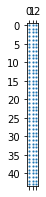

2m:  44
n:  3


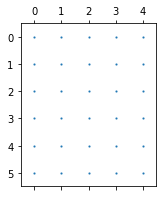

2m:  6
n:  5


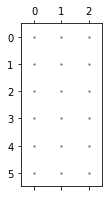

2m:  6
n:  3


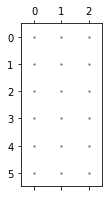

2m:  6
n:  3


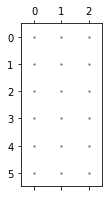

2m:  6
n:  3


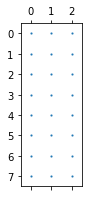

2m:  8
n:  3


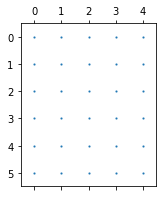

2m:  6
n:  5


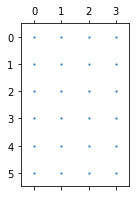

2m:  6
n:  4


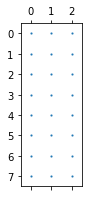

2m:  8
n:  3


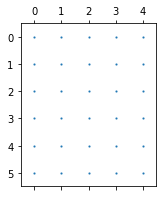

2m:  6
n:  5


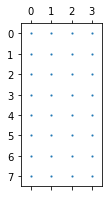

2m:  8
n:  4


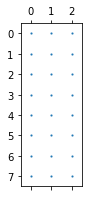

2m:  8
n:  3


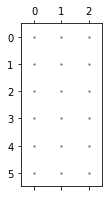

2m:  6
n:  3


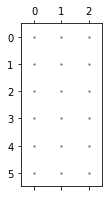

2m:  6
n:  3


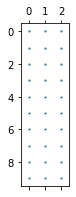

2m:  10
n:  3


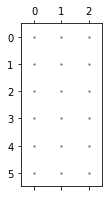

2m:  6
n:  3


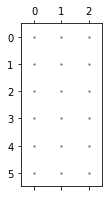

2m:  6
n:  3


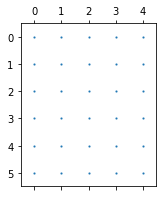

2m:  6
n:  5


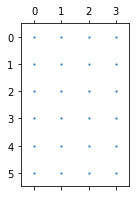

2m:  6
n:  4


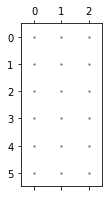

2m:  6
n:  3


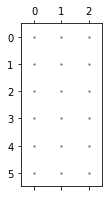

2m:  6
n:  3


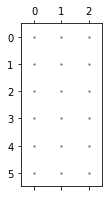

2m:  6
n:  3


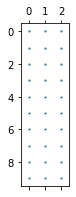

2m:  10
n:  3


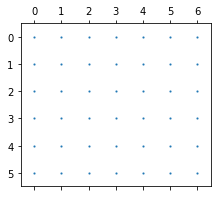

2m:  6
n:  7


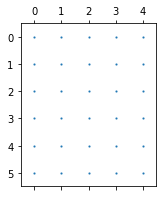

2m:  6
n:  5


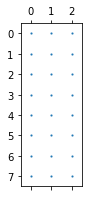

2m:  8
n:  3


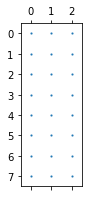

2m:  8
n:  3


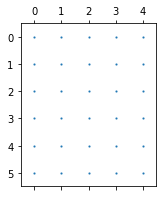

2m:  6
n:  5


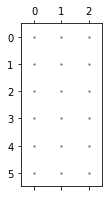

2m:  6
n:  3


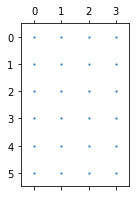

2m:  6
n:  4


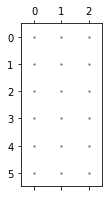

2m:  6
n:  3


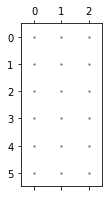

2m:  6
n:  3


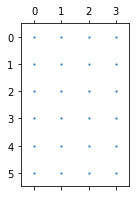

2m:  6
n:  4


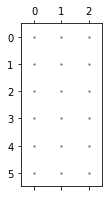

2m:  6
n:  3


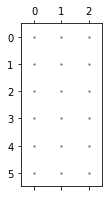

2m:  6
n:  3


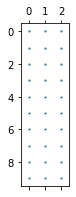

2m:  10
n:  3


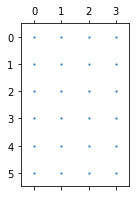

2m:  6
n:  4


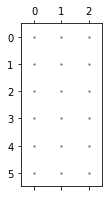

2m:  6
n:  3


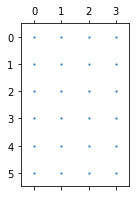

2m:  6
n:  4


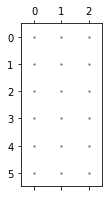

2m:  6
n:  3


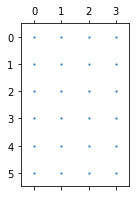

2m:  6
n:  4


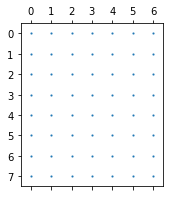

2m:  8
n:  7


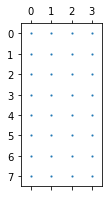

2m:  8
n:  4


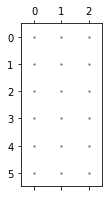

2m:  6
n:  3


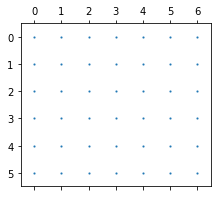

2m:  6
n:  7


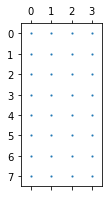

2m:  8
n:  4


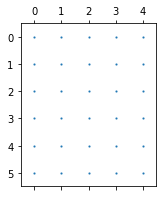

2m:  6
n:  5


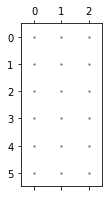

2m:  6
n:  3


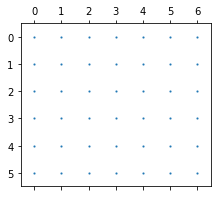

2m:  6
n:  7


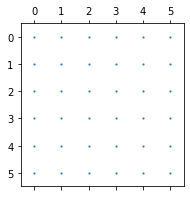

2m:  6
n:  6


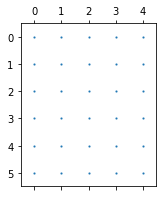

2m:  6
n:  5


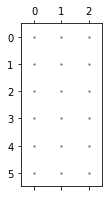

2m:  6
n:  3


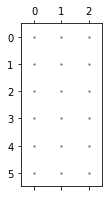

2m:  6
n:  3


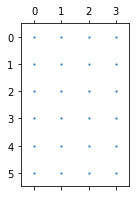

2m:  6
n:  4


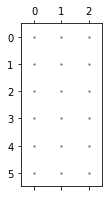

2m:  6
n:  3


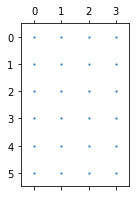

2m:  6
n:  4


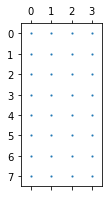

2m:  8
n:  4


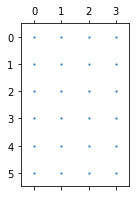

2m:  6
n:  4


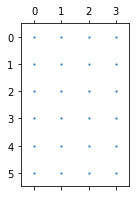

2m:  6
n:  4


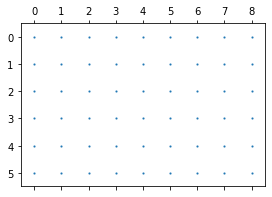

2m:  6
n:  9


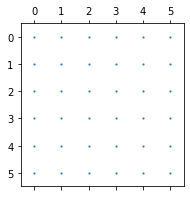

2m:  6
n:  6


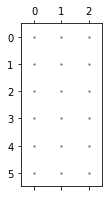

2m:  6
n:  3


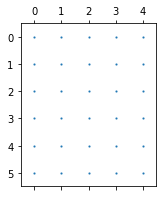

2m:  6
n:  5


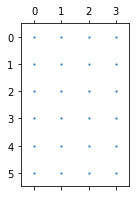

2m:  6
n:  4


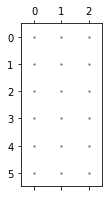

2m:  6
n:  3


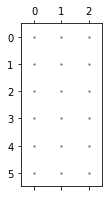

2m:  6
n:  3


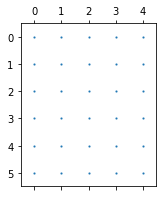

2m:  6
n:  5


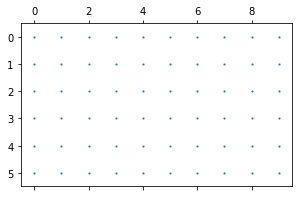

2m:  6
n:  10


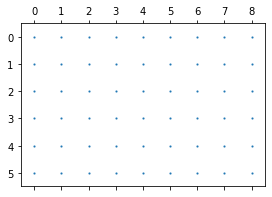

2m:  6
n:  9


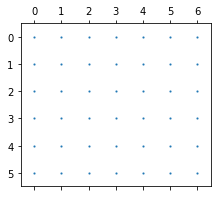

2m:  6
n:  7


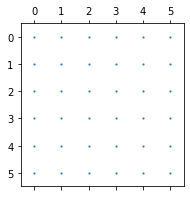

2m:  6
n:  6


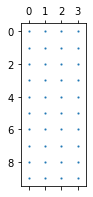

2m:  10
n:  4


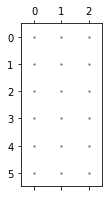

2m:  6
n:  3


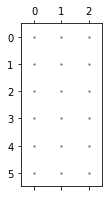

2m:  6
n:  3


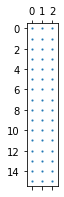

2m:  16
n:  3


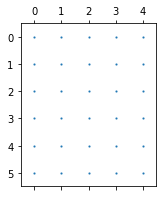

2m:  6
n:  5


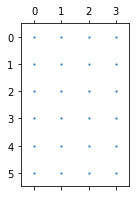

2m:  6
n:  4


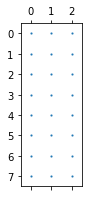

2m:  8
n:  3


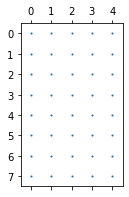

2m:  8
n:  5


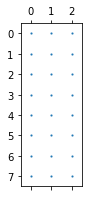

2m:  8
n:  3


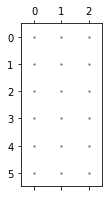

2m:  6
n:  3


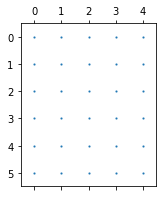

2m:  6
n:  5


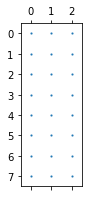

2m:  8
n:  3


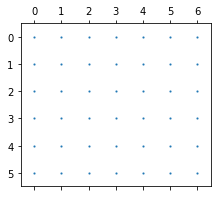

2m:  6
n:  7


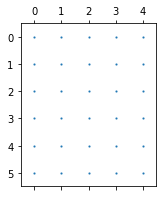

2m:  6
n:  5


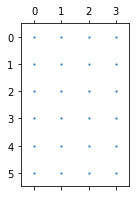

2m:  6
n:  4


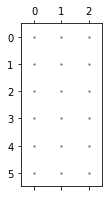

2m:  6
n:  3


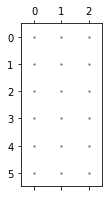

2m:  6
n:  3


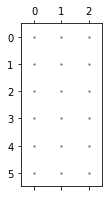

2m:  6
n:  3


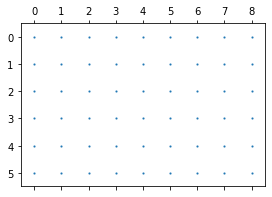

2m:  6
n:  9


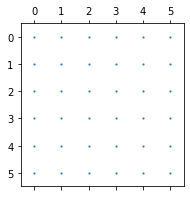

2m:  6
n:  6


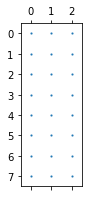

2m:  8
n:  3


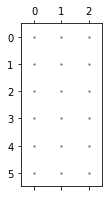

2m:  6
n:  3


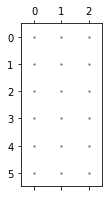

2m:  6
n:  3


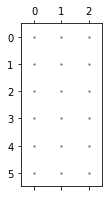

2m:  6
n:  3


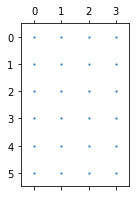

2m:  6
n:  4


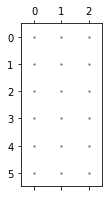

2m:  6
n:  3


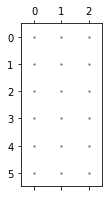

2m:  6
n:  3


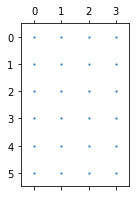

2m:  6
n:  4


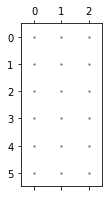

2m:  6
n:  3


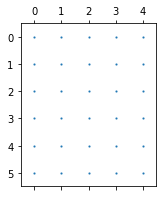

2m:  6
n:  5


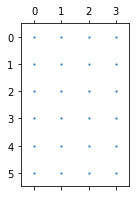

2m:  6
n:  4


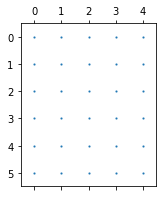

2m:  6
n:  5


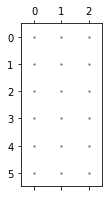

2m:  6
n:  3


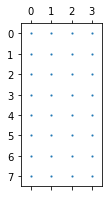

2m:  8
n:  4


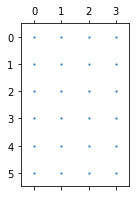

2m:  6
n:  4


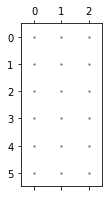

2m:  6
n:  3


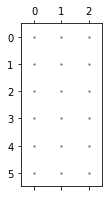

2m:  6
n:  3


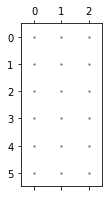

2m:  6
n:  3


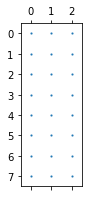

2m:  8
n:  3


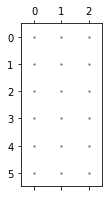

2m:  6
n:  3


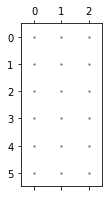

2m:  6
n:  3


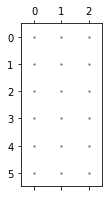

2m:  6
n:  3


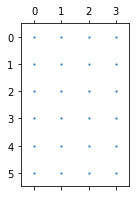

2m:  6
n:  4


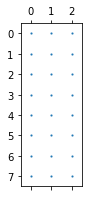

2m:  8
n:  3


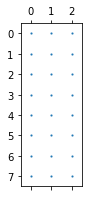

2m:  8
n:  3


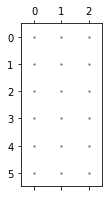

2m:  6
n:  3


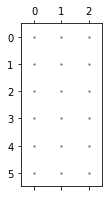

2m:  6
n:  3


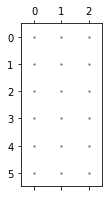

2m:  6
n:  3


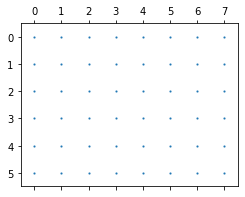

2m:  6
n:  8


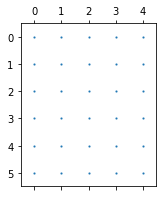

2m:  6
n:  5


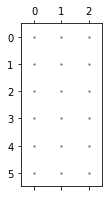

2m:  6
n:  3


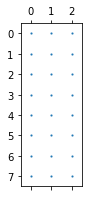

2m:  8
n:  3


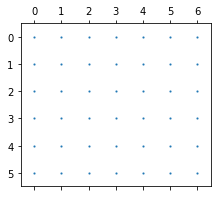

2m:  6
n:  7


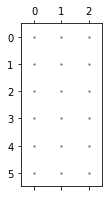

2m:  6
n:  3


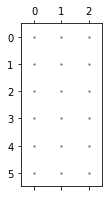

2m:  6
n:  3


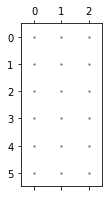

2m:  6
n:  3


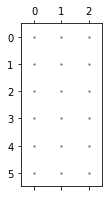

2m:  6
n:  3


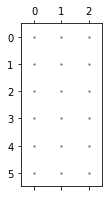

2m:  6
n:  3


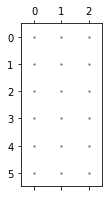

2m:  6
n:  3


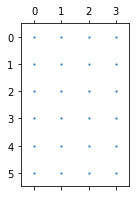

2m:  6
n:  4


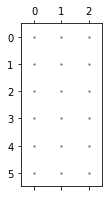

2m:  6
n:  3


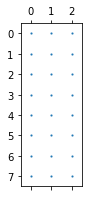

2m:  8
n:  3


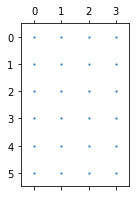

2m:  6
n:  4


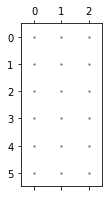

2m:  6
n:  3


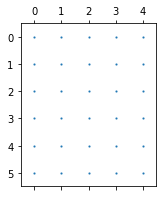

2m:  6
n:  5


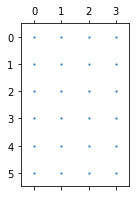

2m:  6
n:  4


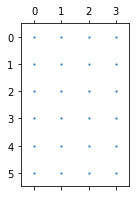

2m:  6
n:  4


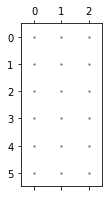

2m:  6
n:  3


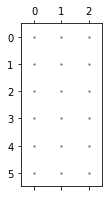

2m:  6
n:  3


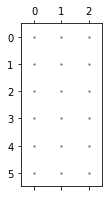

2m:  6
n:  3


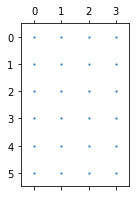

2m:  6
n:  4


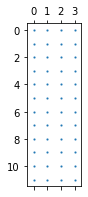

2m:  12
n:  4


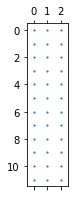

2m:  12
n:  3


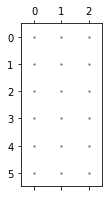

2m:  6
n:  3


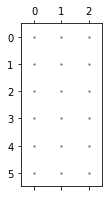

2m:  6
n:  3


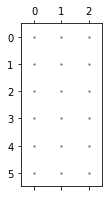

2m:  6
n:  3


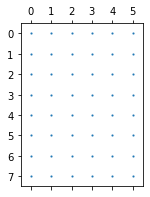

2m:  8
n:  6


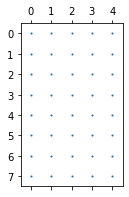

2m:  8
n:  5


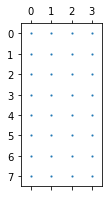

2m:  8
n:  4


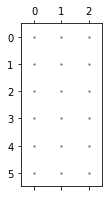

2m:  6
n:  3


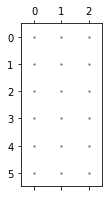

2m:  6
n:  3


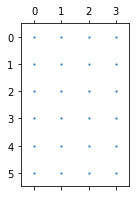

2m:  6
n:  4


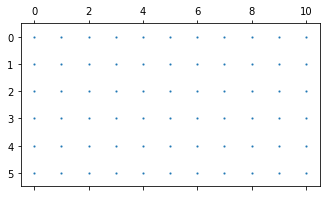

2m:  6
n:  11


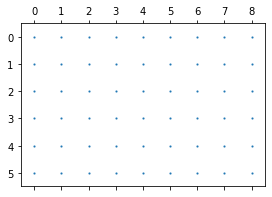

2m:  6
n:  9


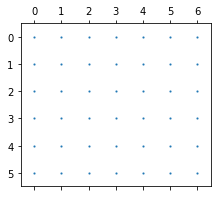

2m:  6
n:  7


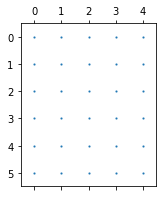

2m:  6
n:  5


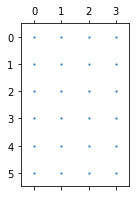

2m:  6
n:  4


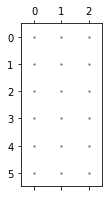

2m:  6
n:  3


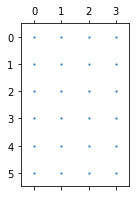

2m:  6
n:  4


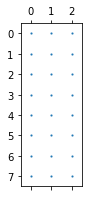

2m:  8
n:  3


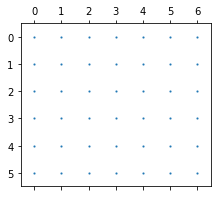

2m:  6
n:  7


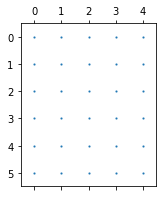

2m:  6
n:  5


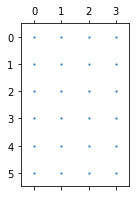

2m:  6
n:  4


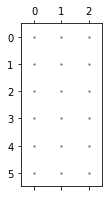

2m:  6
n:  3


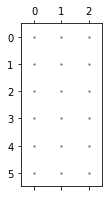

2m:  6
n:  3


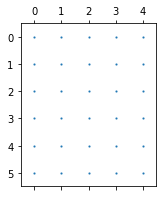

2m:  6
n:  5


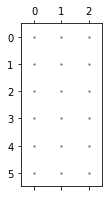

2m:  6
n:  3


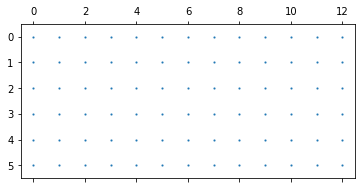

2m:  6
n:  13


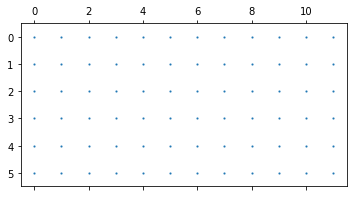

2m:  6
n:  12


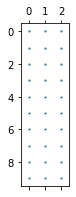

2m:  10
n:  3


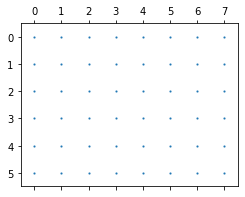

2m:  6
n:  8


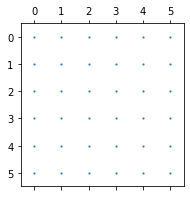

2m:  6
n:  6


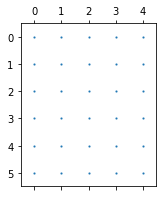

2m:  6
n:  5


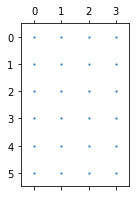

2m:  6
n:  4


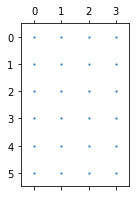

2m:  6
n:  4


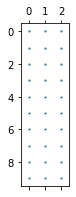

2m:  10
n:  3


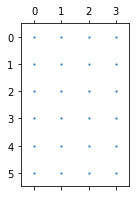

2m:  6
n:  4


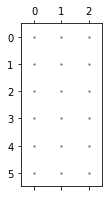

2m:  6
n:  3


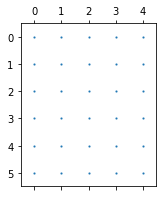

2m:  6
n:  5


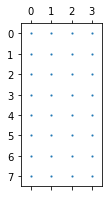

2m:  8
n:  4


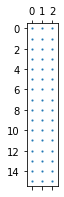

2m:  16
n:  3


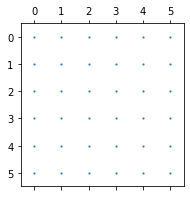

2m:  6
n:  6


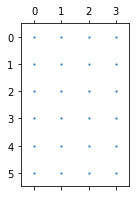

2m:  6
n:  4


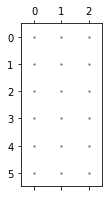

2m:  6
n:  3


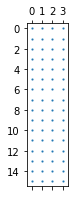

2m:  16
n:  4


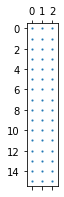

2m:  16
n:  3


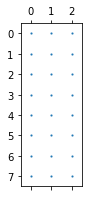

2m:  8
n:  3


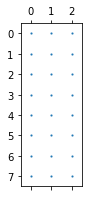

2m:  8
n:  3


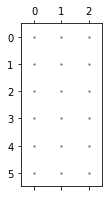

2m:  6
n:  3


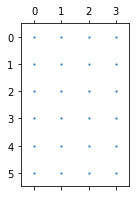

2m:  6
n:  4


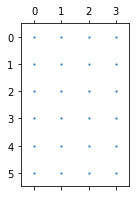

2m:  6
n:  4


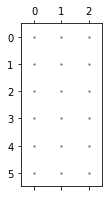

2m:  6
n:  3


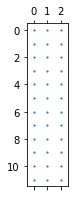

2m:  12
n:  3


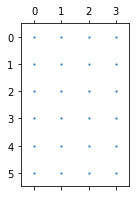

2m:  6
n:  4


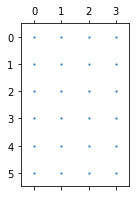

2m:  6
n:  4


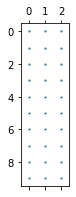

2m:  10
n:  3


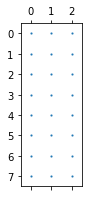

2m:  8
n:  3


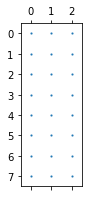

2m:  8
n:  3


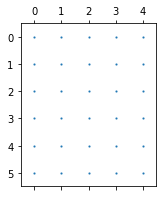

2m:  6
n:  5


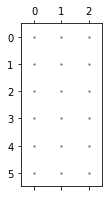

2m:  6
n:  3


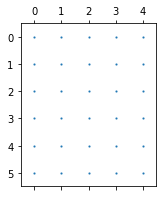

2m:  6
n:  5


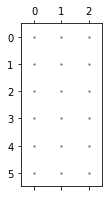

2m:  6
n:  3


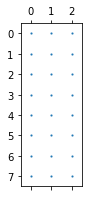

2m:  8
n:  3


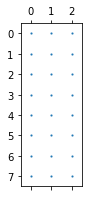

2m:  8
n:  3


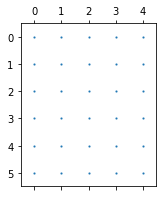

2m:  6
n:  5


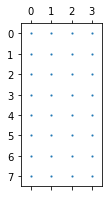

2m:  8
n:  4


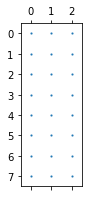

2m:  8
n:  3


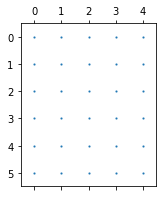

2m:  6
n:  5


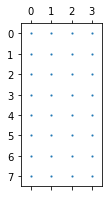

2m:  8
n:  4


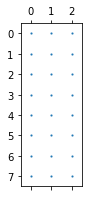

2m:  8
n:  3


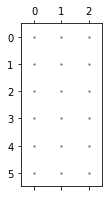

2m:  6
n:  3


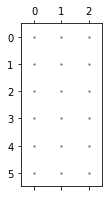

2m:  6
n:  3


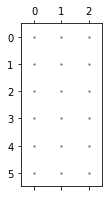

2m:  6
n:  3


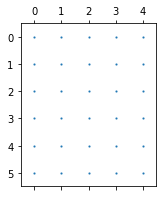

2m:  6
n:  5


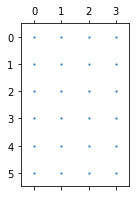

2m:  6
n:  4


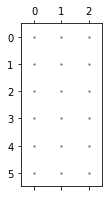

2m:  6
n:  3


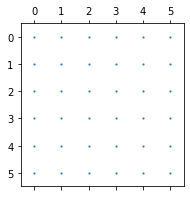

2m:  6
n:  6


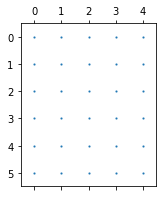

2m:  6
n:  5


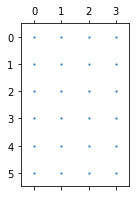

2m:  6
n:  4


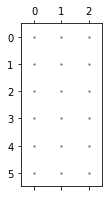

2m:  6
n:  3


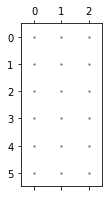

2m:  6
n:  3


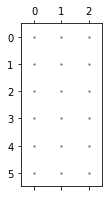

2m:  6
n:  3


In [49]:
from tqdm.notebook import tqdm

s_list = []
for dense_block in tqdm(dense_blocks_list, total=len(dense_blocks_list)):
    y1, y2, x1, x2 = dense_block

    plt.figure(figsize=(6, 3))
    plt.spy(PVM[y1: y2, x1: x2], precision=1e-4, markersize=1)
    plt.show()
    
    S = factorize_and_stitch(PVM[y1: y2, x1: x2])
    s_list.append(S)

start allignment from the largest subblock

procrustes receives two matrices. each matrix, n rows represent points in k (columns) space

Thus, in practice, we pick an arbitrary block as root, and iteratively register all others with this one using linear least squares, before using a non-linear method to refine the global registration parameters.  

We choose the largest block as root node and use its coordinate system as the global frame. We then find the best path from the root to every other node using a measure that maximizes the number of points shared by adjacent blocks, the rationale being that large overlaps will give reliable estimates of the corresponding (local) registration parameters. Specifically, we assign to each edge a capacity (number of points common to the blocks associated with the incident vertices), and use a form of Dijkstra’s algorithm to find for each vertex the path maximizing the capacity reaching the root.

In [50]:
def stardardize(mtx):
    trace = (mtx @ mtx.T).trace()
    mtx_stand = mtx / np.sqrt(trace)
    return mtx_stand

In [51]:
mtx1_stand = stardardize(s_list[0])

already_alligned_standardized = [mtx1_stand]

for points_to_allign in s_list[1:]:
    
    root = np.vstack(already_alligned_standardized)
    points_to_allign = points_to_allign.T
    
    pad_num = root.shape[0] - points_to_allign.shape[0]
    print(f'accumulated shape: {root.shape[0]} procrusted with {points_to_allign.shape[0]}')

    if pad_num >= 0:
        shape_before = points_to_allign.shape
        print(f'Adding {pad_num} zero points to the new S')
        points_to_allign = np.pad(points_to_allign, [(0, abs(pad_num)), (0, 0)], constant_values=0)
    else:
        root = np.pad(root, [(0, abs(pad_num)), (0, 0)], constant_values=0)
        print(f'Adding {abs(pad_num)} zero points to the accumulated')
        
    print(f'Procrusting matrices of shapes {root.shape} and {points_to_allign.shape}')
    mtx1, mtx2, _ = procrustes(root, points_to_allign)
    
    # NOT SURE ABOUT THIS MOMENT
    if pad_num >= 0:  # returning to the original shape = dropping added zeros
        mtx2 = mtx2[: shape_before[0], :shape_before[1]]

    mtx2_stand = stardardize(mtx2)

    assert np.isclose((mtx2_stand @ mtx2_stand.T).trace(), 1.,
                      rtol=1e-05, atol=1e-08)
    assert np.isclose((mtx1 @ mtx1.T).trace(), 1.,
                      rtol=1e-05, atol=1e-08)

    already_alligned_standardized.append(mtx2_stand)
    print('\n')

accumulated shape: 3 procrusted with 5
Adding 2 zero points to the accumulated
Procrusting matrices of shapes (5, 3) and (5, 3)


accumulated shape: 8 procrusted with 3
Adding 5 zero points to the new S
Procrusting matrices of shapes (8, 3) and (8, 3)


accumulated shape: 11 procrusted with 3
Adding 8 zero points to the new S
Procrusting matrices of shapes (11, 3) and (11, 3)


accumulated shape: 14 procrusted with 3
Adding 11 zero points to the new S
Procrusting matrices of shapes (14, 3) and (14, 3)


accumulated shape: 17 procrusted with 3
Adding 14 zero points to the new S
Procrusting matrices of shapes (17, 3) and (17, 3)


accumulated shape: 20 procrusted with 5
Adding 15 zero points to the new S
Procrusting matrices of shapes (20, 3) and (20, 3)


accumulated shape: 25 procrusted with 4
Adding 21 zero points to the new S
Procrusting matrices of shapes (25, 3) and (25, 3)


accumulated shape: 29 procrusted with 3
Adding 26 zero points to the new S
Procrusting matrices of shapes (



accumulated shape: 491 procrusted with 3
Adding 488 zero points to the new S
Procrusting matrices of shapes (491, 3) and (491, 3)


accumulated shape: 494 procrusted with 7
Adding 487 zero points to the new S
Procrusting matrices of shapes (494, 3) and (494, 3)


accumulated shape: 501 procrusted with 3
Adding 498 zero points to the new S
Procrusting matrices of shapes (501, 3) and (501, 3)


accumulated shape: 504 procrusted with 3
Adding 501 zero points to the new S
Procrusting matrices of shapes (504, 3) and (504, 3)


accumulated shape: 507 procrusted with 3
Adding 504 zero points to the new S
Procrusting matrices of shapes (507, 3) and (507, 3)


accumulated shape: 510 procrusted with 3
Adding 507 zero points to the new S
Procrusting matrices of shapes (510, 3) and (510, 3)


accumulated shape: 513 procrusted with 3
Adding 510 zero points to the new S
Procrusting matrices of shapes (513, 3) and (513, 3)


accumulated shape: 516 procrusted with 3
Adding 513 zero points to the new



accumulated shape: 871 procrusted with 5
Adding 866 zero points to the new S
Procrusting matrices of shapes (871, 3) and (871, 3)


accumulated shape: 876 procrusted with 4
Adding 872 zero points to the new S
Procrusting matrices of shapes (876, 3) and (876, 3)


accumulated shape: 880 procrusted with 3
Adding 877 zero points to the new S
Procrusting matrices of shapes (880, 3) and (880, 3)


accumulated shape: 883 procrusted with 6
Adding 877 zero points to the new S
Procrusting matrices of shapes (883, 3) and (883, 3)


accumulated shape: 889 procrusted with 5
Adding 884 zero points to the new S
Procrusting matrices of shapes (889, 3) and (889, 3)


accumulated shape: 894 procrusted with 4
Adding 890 zero points to the new S
Procrusting matrices of shapes (894, 3) and (894, 3)


accumulated shape: 898 procrusted with 3
Adding 895 zero points to the new S
Procrusting matrices of shapes (898, 3) and (898, 3)


accumulated shape: 901 procrusted with 3
Adding 898 zero points to the new

In [52]:
points = []

for mtx in already_alligned_standardized:
    p = o3d.geometry.PointCloud()
    p.points = o3d.utility.Vector3dVector(mtx)
    points.append(deepcopy(p))

In [53]:
o3d.visualization.draw_geometries(points) 

## 4 images